In [1]:
import os, glob, numpy as np, torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import itertools

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    cohen_kappa_score,
    classification_report
)

In [4]:
DATA_DIR = '/content/drive/MyDrive/Stat483-GOALZ/4830_project/sleepedf_data/processed_sleepedf'
RESULT_DIR = '/content/drive/MyDrive/Stat483-GOALZ/4830_project/sleepedf_results'
os.makedirs(RESULT_DIR, exist_ok=True)

In [5]:
print("Files in directory:", os.listdir(DATA_DIR))

Files in directory: ['SC4201E0_epochs.npz', 'SC4171E0_epochs.npz', 'SC4201E0_sequences.npz', 'SC4171E0_sequences.npz', 'SC4272F0_epochs.npz', 'SC4421E0_epochs.npz', 'SC4421E0_sequences.npz', 'SC4272F0_sequences.npz', 'SC4452F0_epochs.npz', 'SC4622E0_epochs.npz', 'SC4452F0_sequences.npz', 'SC4622E0_sequences.npz', 'SC4592G0_epochs.npz', 'SC4002E0_epochs.npz', 'SC4592G0_sequences.npz', 'SC4002E0_sequences.npz', 'SC4112E0_epochs.npz', 'SC4482F0_epochs.npz', 'SC4112E0_sequences.npz', 'SC4482F0_sequences.npz', 'SC4442E0_epochs.npz', 'SC4802G0_epochs.npz', 'SC4442E0_sequences.npz', 'SC4802G0_sequences.npz', 'SC4542F0_epochs.npz', 'SC4542F0_sequences.npz', 'SC4531E0_epochs.npz', 'SC4362F0_epochs.npz', 'SC4531E0_sequences.npz', 'SC4362F0_sequences.npz', 'SC4061E0_epochs.npz', 'SC4311E0_epochs.npz', 'SC4061E0_sequences.npz', 'SC4311E0_sequences.npz', 'SC4232E0_epochs.npz', 'SC4142E0_epochs.npz', 'SC4232E0_sequences.npz', 'SC4142E0_sequences.npz', 'SC4461F0_epochs.npz', 'SC4412E0_epochs.npz', 'S

In [6]:
BATCH_SIZE = 16
NUM_EPOCHS = 20
LEARNING_RATE = 1e-3
TRAIN_VAL_SPLIT = 0.8
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
print("CUDA available:", torch.cuda.is_available())

CUDA available: True


In [8]:
EMBEDDING_DIM = 128   # Dimension of the CNN encoder output per epoch
NUM_CLASSES = 5       # 0: Wake, 1: N1, 2: N2, 3: N3, 4: REM
NUM_TRANSFORMER_LAYERS = 2
NUM_HEADS = 4
DROPOUT = 0.1
SEQ_LENGTH = 20       # Number of epochs per sequence (must match preprocessing)

In [9]:
class SleepSequenceDataset(Dataset):
    def __init__(self, data_dir):
        # Find all NPZ files ending with _sequences.npz
        self.files = glob.glob(os.path.join(data_dir, '*_sequences.npz'))
        sequences_list = []
        labels_list = []
        for f in self.files:
            loaded = np.load(f)
            sequences_list.append(loaded['sequences'])  # shape: (n_seq, 20, 2, 3000)
            labels_list.append(loaded['seq_labels'])      # shape: (n_seq, 20)
        self.sequences = np.concatenate(sequences_list, axis=0)
        self.seq_labels = np.concatenate(labels_list, axis=0)
        self.sequences = torch.from_numpy(self.sequences).float()
        self.seq_labels = torch.from_numpy(self.seq_labels).long()

    def __len__(self):
        return self.sequences.shape[0]

    def __getitem__(self, idx):
        return self.sequences[idx], self.seq_labels[idx]

In [10]:
class EpochEncoder(nn.Module):
    def __init__(self, embedding_dim):
        super(EpochEncoder, self).__init__()
        self.net = nn.Sequential(
            nn.Conv1d(in_channels=2, out_channels=16, kernel_size=50, stride=6),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=8, stride=8),
            nn.Conv1d(in_channels=16, out_channels=32, kernel_size=8, stride=2),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=4, stride=4)
        )
        #Passing dummy input to automatically calculate no. of features and avoid mismatch error
        with torch.no_grad():
            dummy_input = torch.zeros(1, 2, 3000)
            dummy_output = self.net(dummy_input)
            n_features = dummy_output.numel() // dummy_output.shape[0]  # Total features per sample
        self.fc = nn.Linear(n_features, embedding_dim)
        # The output dimension is computed approximately based on the input size 3000
        #self.fc = nn.Linear(32 * (((3000 - 50) // 6 + 1) // 8 // 4), embedding_dim)

    def forward(self, x):
        # x: (batch, 2, 3000)
        out = self.net(x)
        out = out.view(out.size(0), -1)
        embedding = self.fc(out)
        return embedding

In [11]:
class SleepTransformer(nn.Module):
    def __init__(self, embedding_dim, num_classes, num_layers, num_heads, dropout, seq_length):
        super(SleepTransformer, self).__init__()
        self.encoder = EpochEncoder(embedding_dim) #create embeddings using features (catch22) and then add the transformer to it
        encoder_layer = nn.TransformerEncoderLayer(d_model=embedding_dim, nhead=num_heads, dropout=dropout)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.classifier = nn.Linear(embedding_dim, num_classes)
        self.seq_length = seq_length

    def forward(self, x):
        # x: (batch, seq_length, 2, 3000)
        batch_size, seq_len = x.size(0), x.size(1)
        x = x.view(-1, x.size(2), x.size(3))  # (batch*seq_length, 2, 3000)
        epoch_emb = self.encoder(x)           # (batch*seq_length, embedding_dim)
        epoch_emb = epoch_emb.view(batch_size, seq_len, -1)
        epoch_emb = epoch_emb.transpose(0, 1)   # (seq_length, batch, embedding_dim)
        transformer_out = self.transformer(epoch_emb)
        transformer_out = transformer_out.transpose(0, 1)  # (batch, seq_length, embedding_dim)
        logits = self.classifier(transformer_out)  # (batch, seq_length, num_classes)
        return logits

In [12]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    for seq, labels in dataloader:
        seq, labels = seq.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = model(seq)  # (batch, seq_length, num_classes)
        loss = criterion(logits.view(-1, NUM_CLASSES), labels.view(-1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * seq.size(0)
        preds = torch.argmax(logits, dim=-1)
        all_preds.append(preds.cpu().detach().numpy())
        all_labels.append(labels.cpu().detach().numpy())
    epoch_loss = running_loss / len(dataloader.dataset)
    all_preds = np.concatenate(all_preds).flatten()
    all_labels = np.concatenate(all_labels).flatten()
    acc = accuracy_score(all_labels, all_preds)
    return epoch_loss, acc

In [13]:
import torch.nn.functional as F

def eval_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    all_probs = []  # <--- store probabilities for ROC

    with torch.no_grad():
        for seq, labels in dataloader:
            seq, labels = seq.to(device), labels.to(device)
            logits = model(seq)  # shape: (batch, seq_length, NUM_CLASSES)

            # Compute loss
            loss = criterion(logits.view(-1, NUM_CLASSES), labels.view(-1))
            running_loss += loss.item() * seq.size(0)

            # Predicted classes
            preds = torch.argmax(logits, dim=-1)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

            # Softmax probabilities for ROC
            probs = F.softmax(logits, dim=-1)  # shape: (batch, seq_length, NUM_CLASSES)
            all_probs.append(probs.cpu().numpy())

    # Convert lists to NumPy arrays
    epoch_loss = running_loss / len(dataloader.dataset)
    all_preds = np.concatenate(all_preds).ravel()    # shape: (N,)
    all_labels = np.concatenate(all_labels).ravel()  # shape: (N,)

    # Flatten probabilities to shape (N, NUM_CLASSES)
    all_probs = np.concatenate(all_probs, axis=0).reshape(-1, NUM_CLASSES)

    acc = accuracy_score(all_labels, all_preds)

    # Now we return 5 items, including val_probs
    return epoch_loss, acc, all_preds, all_labels, all_probs


In [14]:
def plot_curves(train_losses, val_losses, train_accs, val_accs):
    epochs = range(1, len(train_losses)+1)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(epochs, train_accs, label='Train Acc')
    plt.plot(epochs, val_accs, label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [15]:
def plot_confusion(all_labels, all_preds):
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6,6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    classes = ['W', 'N1', 'N2', 'N3', 'R']
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

In [16]:
from sklearn.metrics import confusion_matrix, accuracy_score

In [17]:
from tqdm.notebook import tqdm

In [22]:
def compute_metrics(y_true, y_pred, class_names=None):
    """
    Compute and print various classification metrics.
    y_true, y_pred: 1D numpy arrays of integer class labels.
    class_names: Optional list of class names (e.g. ["W", "N1", "N2", "N3", "REM"]).
    """
    # Overall accuracy
    acc = accuracy_score(y_true, y_pred)

    # F1 scores
    f1_macro = f1_score(y_true, y_pred, average='macro')
    f1_per_class = f1_score(y_true, y_pred, average=None)

    # Cohen’s Kappa
    kappa = cohen_kappa_score(y_true, y_pred)

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Sensitivity & Specificity per class
    # (Note: "sensitivity" is the same as "recall" for that class)
    #        "specificity" = TN / (TN + FP)
    # We can compute them from the confusion matrix:
    #    TP = cm[i, i]
    #    FN = sum(cm[i, :]) - cm[i, i]
    #    FP = sum(cm[:, i]) - cm[i, i]
    #    TN = total_sum - (TP + FN + FP)
    total_sum = cm.sum()
    per_class_sens = []
    per_class_spec = []
    for i in range(cm.shape[0]):
        TP = cm[i, i]
        FN = cm[i, :].sum() - TP
        FP = cm[:, i].sum() - TP
        TN = total_sum - (TP + FN + FP)

        sensitivity = TP / (TP + FN + 1e-9)
        specificity = TN / (TN + FP + 1e-9)
        per_class_sens.append(sensitivity)
        per_class_spec.append(specificity)

    # Print classification report
    # This automatically shows precision, recall, F1, and support for each class
    if class_names is not None:
        print("\nClassification Report:")
        print(classification_report(y_true, y_pred, target_names=class_names, digits=4))
    else:
        print("\nClassification Report:")
        print(classification_report(y_true, y_pred, digits=4))

    # Organize everything in a dictionary
    metrics_dict = {
        'Accuracy': acc,
        'Macro_F1': f1_macro,
        'F1_per_class': f1_per_class,
        'Cohen_Kappa': kappa,
        'Sensitivity_per_class': per_class_sens,
        'Specificity_per_class': per_class_spec
    }
    return metrics_dict

In [19]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

def plot_roc_curves(y_true, y_score, class_names=None):
    """
    Plot one-vs-rest ROC curves for each class in a multi-class setting.

    Parameters:
    -----------
    y_true : 1D array-like of shape (N,)
        Ground truth integer labels (0..num_classes-1).
    y_score : 2D array-like of shape (N, num_classes)
        Predicted probabilities for each class (softmax output).
    class_names : list of str, optional
        Class names to display in the legend. Must have length == num_classes.
    """
    n_classes = y_score.shape[1]

    # Binarize the labels for a one-vs-rest ROC
    # e.g. [0,2,1,...] -> [[1,0,0,0,0], [0,0,1,0,0], [0,1,0,0,0], ...]
    y_true_bin = label_binarize(y_true, classes=range(n_classes))

    fpr = {}
    tpr = {}
    roc_auc = {}

    # Compute ROC curve and AUC for each class
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all ROC curves
    plt.figure(figsize=(7,7))
    colors = ['blue', 'red', 'green', 'purple', 'orange', 'cyan', 'darkgreen']
    for i in range(n_classes):
        if class_names and i < len(class_names):
            label_str = f"{class_names[i]} (AUC = {roc_auc[i]:.2f})"
        else:
            label_str = f"Class {i} (AUC = {roc_auc[i]:.2f})"
        plt.plot(fpr[i], tpr[i], color=colors[i % len(colors)], lw=2, label=label_str)

    # Plot a random guess line
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves per Class')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
dataset = SleepSequenceDataset(DATA_DIR)

In [20]:
# Load dataset from processed sequence NPZ files
total_len = len(dataset)
train_len = int(TRAIN_VAL_SPLIT * total_len)
val_len = total_len - train_len
train_dataset, val_dataset = random_split(dataset, [train_len, val_len])
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

model = SleepTransformer(EMBEDDING_DIM, NUM_CLASSES, NUM_TRANSFORMER_LAYERS, NUM_HEADS, DROPOUT, SEQ_LENGTH)
model.to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in tqdm(range(1, NUM_EPOCHS+1), desc="Training Epochs"):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, DEVICE)
    val_loss, val_acc, val_preds, val_labels, _ = eval_epoch(model, val_loader, criterion, DEVICE)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    print(f"Epoch {epoch}/{NUM_EPOCHS}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")

plot_curves(train_losses, val_losses, train_accs, val_accs)
_, _, val_preds, val_labels, _ = eval_epoch(model, val_loader, criterion, DEVICE)
plot_confusion(val_labels, val_preds)

    # Save the model checkpoint in RESULT_DIR
    #torch.save(model.state_dict(), os.path.join(RESULT_DIR, 'sleep_transformer_model.pth'))

ConnectionAbortedError: [Errno 103] Software caused connection abort

In [ ]:
_, _, val_preds, val_labels, _ = eval_epoch(model, val_loader, criterion, DEVICE)
metrics_dict = compute_metrics(val_labels, val_preds, class_names=["W","N1","N2","N3","REM"])
print(metrics_dict)


Classification Report:
              precision    recall  f1-score   support

           W     0.8338    0.8234    0.8286       719
          N1     0.6689    0.5601    0.6097       707
          N2     0.8712    0.9258    0.8977      4704
          N3     0.8672    0.8389    0.8528      1440
         REM     0.9082    0.8492    0.8777      1910

    accuracy                         0.8621      9480
   macro avg     0.8299    0.7995    0.8133      9480
weighted avg     0.8601    0.8621    0.8601      9480

{'Accuracy': 0.8621308016877637, 'Macro_F1': 0.8132847122379451, 'F1_per_class': array([0.82855143, 0.60969977, 0.89766052, 0.85280621, 0.87770563]), 'Cohen_Kappa': np.float64(0.7935245927728375), 'Sensitivity_per_class': [np.float64(0.8233657858124849), np.float64(0.5601131541717679), np.float64(0.9258078231290549), np.float64(0.8388888888883064), np.float64(0.8492146596854193)], 'Specificity_per_class': [np.float64(0.9865312178973876), np.float64(0.9776587256353609), np.float64(0.

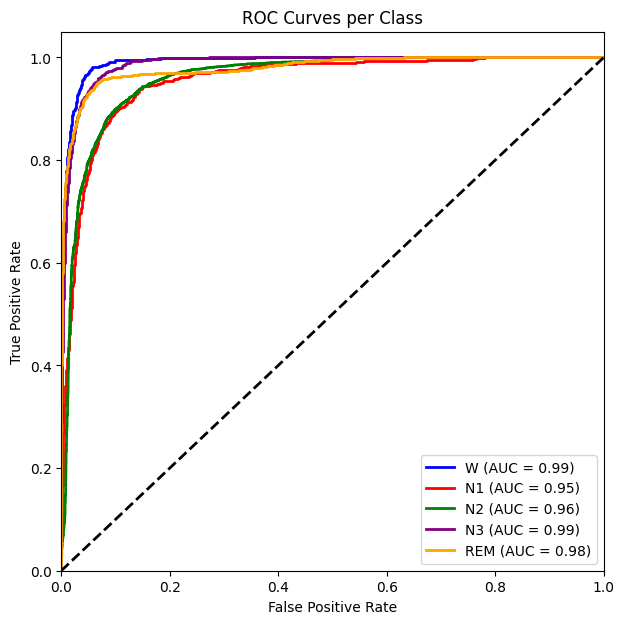

In [ ]:
val_loss, val_acc, val_preds, val_labels, val_probs = eval_epoch(
    model, val_loader, criterion, DEVICE
)

plot_roc_curves(val_labels, val_probs, class_names=["W","N1","N2","N3","REM"])